In [351]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

# Paleta de Analisis

In [393]:
hue_steps = 18
hue_range = 360
hue_step_size = int(360/hue_steps)

hues = np.array([(hue_step/hue_range) for hue_step in range(0, hue_range, hue_step_size)])
example_hues = np.array([(hue_step, 0.5, 0.5) for hue_step in hues])

luminances = np.array([0, 0.33, 0.66, 1])
hue_luminance = np.transpose([np.tile(hues, len(luminances)), np.repeat(luminances, len(hues))]).copy()
saturations = np.array([0, 0.33, 0.66, 1])

hls_stack = []
for saturation in saturations:
    hls_array_proto = np.zeros((hue_luminance.shape[0], hue_luminance.shape[1] + 1))
    hls_array_proto[:, :2] = hue_luminance.copy()
    
    hls_array_proto[:, 2] = saturation
    hls_stack.append(hls_array_proto)
    
cube = np.stack(hls_stack).reshape(-1,3)

In [394]:
pd_cube = pd.DataFrame(cube, columns=['hue', 'luminance', 'saturation'])
pd_cube = pd_cube.sort_values(by=['hue','luminance','saturation']).reset_index(drop=True)
pd_cube = pd_cube.reset_index()

final_cube = pd_cube[['hue','luminance','saturation']].values.reshape(len(hues), len(luminances), len(saturations), 3)
cube_palette = final_cube.reshape(-1, 3)
cube_indices = np.array(list(range(len(cube_palette))))

In [255]:
pd_cube['blanco'] = 1*(pd_cube['luminance'] == 1)
pd_cube['negro'] = 1*(pd_cube['luminance'] == 0)
pd_cube['gris'] = 1*(pd_cube['saturation'] == 0)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])

In [283]:
for idx, hue in enumerate(hues):
    pd_cube['hue_%s' % idx] = 1*(pd_cube['hue'] == hue)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])*(1-pd_cube['gris'])

In [277]:
blancos = list(pd_cube[pd_cube['blanco'] == 1]['index'].values)
negros = list(pd_cube[pd_cube['negro'] == 1]['index'].values)
gris = list(pd_cube[pd_cube['gris'] == 1]['index'].values)

In [332]:
final_analysis_array = [
    ('negros', negros, (0, 0, 0))
    ,('grises', gris, (0, 0.5, 0))
    ,('blancos', blancos, (0, 0.85, 0))
] + [
    (
        'hue_%s' % hue_idx,
        list(pd_cube[pd_cube['hue_%s' % hue_idx] == 1]['index'].values), 
        example_hues[hue_idx]
    )
    for hue_idx in range(len(hues))
]

final_analysis_names = [i[0] for i in final_analysis_array]
final_analysis_palette = np.array([i[2] for i in final_analysis_array])

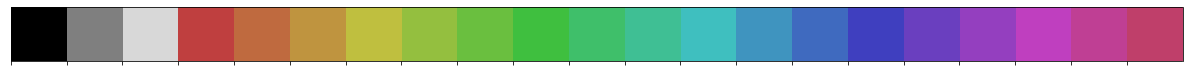

In [333]:
sns.palplot(get_palette(final_analysis_palette))

# Carga archivos

In [264]:
cam = glob.glob('../../Osintgram/output/*.jpg')

In [280]:
signatures = get_image_signatures(cam, analysis_palette=cube_palette)

100%|██████████| 1537/1537 [26:11<00:00,  1.02s/it]


In [321]:
pd_signatures = pd.DataFrame(signatures).fillna(0)

In [323]:
for name, indices, _ in final_analysis_array:
    pd_signatures[name] = pd_signatures[indices].sum(axis=1)

In [325]:
pd_discretized_signature = pd_signatures[final_analysis_names]

In [338]:
pd_discr_weighted_signatures = pd_discretized_signature.apply(lambda x: x/x.sum(), axis=1)

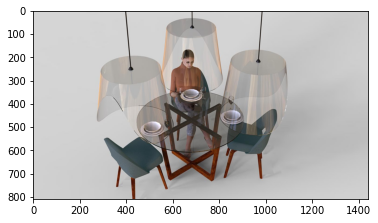

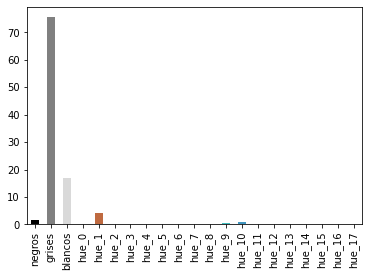

negros      1.447346
grises     75.464823
blancos    17.005820
hue_0       0.258979
hue_1       4.160057
hue_2       0.265503
hue_3       0.000601
hue_4       0.000000
hue_5       0.000343
hue_6       0.000000
hue_7       0.000000
hue_8       0.004034
hue_9       0.600106
hue_10      0.740455
hue_11      0.007296
hue_12      0.027211
hue_13      0.001888
hue_14      0.000773
hue_15      0.000000
hue_16      0.000000
hue_17      0.014764
Name: 140, dtype: float64


In [391]:
img_idx = 140

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

(pd_discr_weighted_signatures.iloc[img_idx]*100).plot.bar(color=get_palette(final_analysis_palette))
plt.show()
print((pd_discr_weighted_signatures.iloc[img_idx]*100))

<AxesSubplot:>

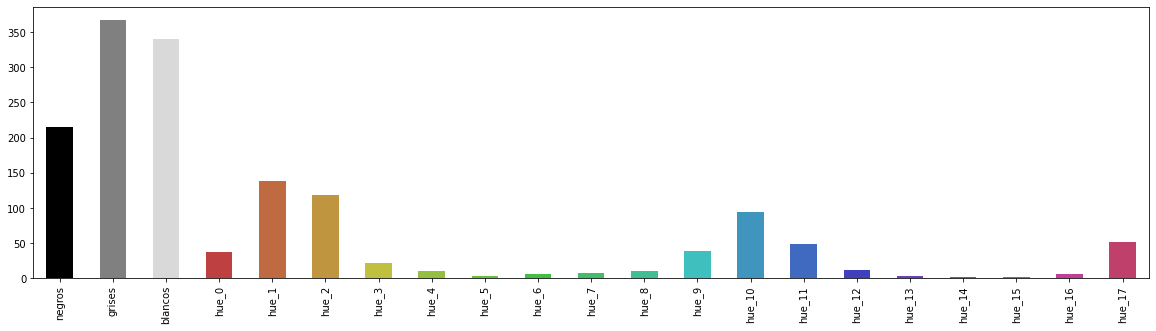

In [340]:
pd_discr_weighted_signatures.sum().plot.bar(color=get_palette(final_analysis_palette))

<AxesSubplot:>

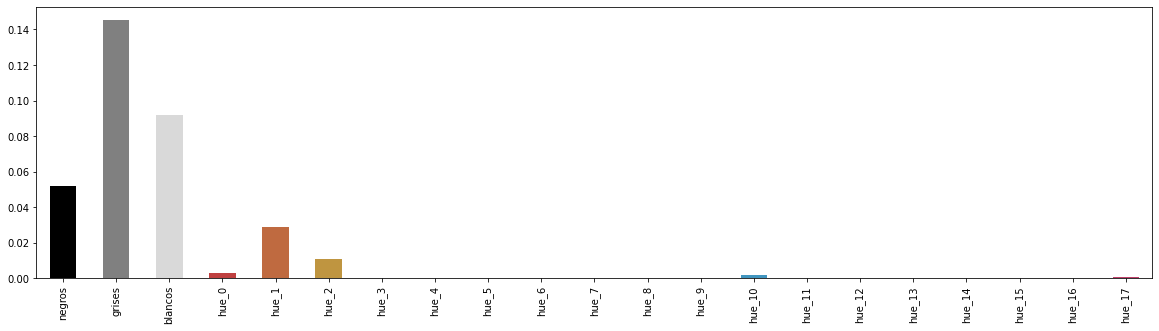

In [341]:
pd_discr_weighted_signatures.median().plot.bar(color=get_palette(final_analysis_palette))

In [20]:
pd_weighted_signatures = pd_signatures.apply(lambda x: x/x.sum(), axis=1)

<AxesSubplot:>

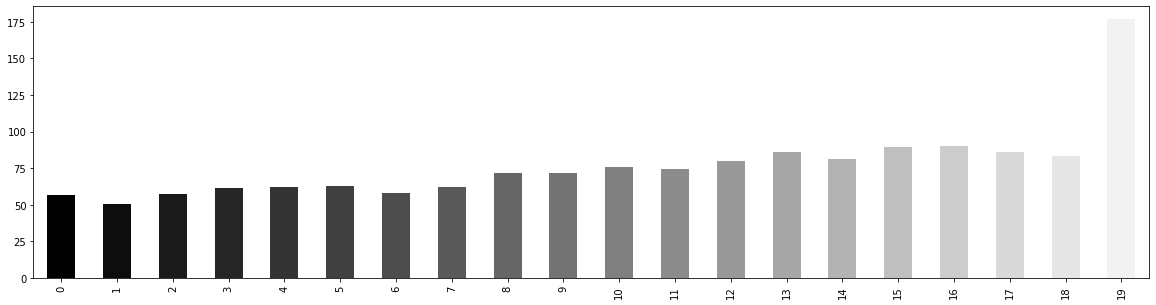

In [22]:
pd_weighted_signatures.sum(axis=0).plot.bar(color=get_palette(paleta_luminancia))

# Pruebas Luminancia y posicion

In [23]:
def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [342]:
img = cam[0]
img_rgb, img_hls = get_img(img)

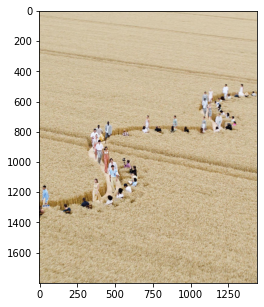

In [345]:
plt.imshow(img_rgb)

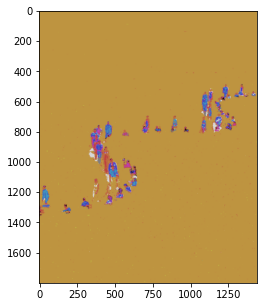

In [348]:
quantized_img = quantize_img_color_wheel(preprocess_img_hls(img_hls), cube_palette)
itten_quantized_img = quantize_img_color_wheel(quantized_img, final_analysis_palette)
plt.imshow(cv2.cvtColor(np.uint8(itten_quantized_img * (180, 255, 255)), cv2.COLOR_HLS2RGB))

In [347]:
quantized_img

array([[[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        ...,
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ]],

       [[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        ...,
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ]],

       [[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        ...,
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ]],

       ...,

       [[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0

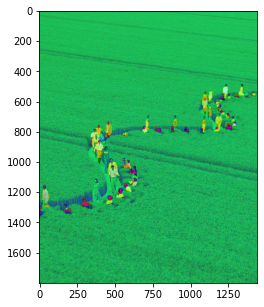

In [343]:
plt.imshow(preprocess_img_hls(img_hls), cmap='gray')